In [93]:
from scipy.spatial import KDTree
import pandas as pd
import geopandas as gpd
from pytz import UTC
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
from typing import Union
import numpy.typing as npt
from typing import List, Tuple
import seaborn as sns
from shapely.geometry import Point, box
from matplotlib.lines import Line2D
from geopandas.tools import sjoin, sjoin_nearest
from scipy.spatial import KDTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance
from sklearn import svm

# Ignore divide by NaN warnings for normalisation from StandardScaler
np.seterr(divide='ignore', invalid='ignore')

# set print options
np.set_printoptions(linewidth=110)
pd.set_option('display.width', 200)
plt.style.use('bmh')  # better for plotting geometries vs general plots.

start = pd.Timestamp('2023-06-01 01:00:00', tz=UTC)
end = start + pd.Timedelta(days=30)
crs = 4326

def create_dataset_for_sensor_id(start, end, neighbours_gdf, sensor_id, freq, provider, nn_count, path, min_values=10, save=True, features: Union[str, List[str], None] = None, use_p_id_labels: bool = False, neighbour_ids: Union["pd.Series[str]", "pd.Series[int]", None] = None) -> pd.DataFrame :
    """
    Creates X and y datasets for a given sensor id.

    Parameters
    ----------
    start : pd.Timestamp
        The start time of the dataset
    end : pd.Timestamp
        The end time of the dataset
    neighbours_gdf : geopandas.GeoDataFrame
        The dataframe with the neighbours
    sensor_id : str
        The sensor id
    freq : int
        The frequency of the dataset in minutes
    provider : str
        The provider of the data
    nn_count : int
        The number of nearest neighbours to include
    path : str
        The path to save the dataset to
    min_values : int
        The minimum number of values in the dataset
    save : bool
        Whether to save the dataset to a file
    features : numpy.ndarray
        The features to include in the dataset. Can be None, "time", "humidity", "pressure",  a combination of those or "all" for all features.
    use_p_id_labels : bool
        If set to false, the p_ids of the neigbours are replaced with integer labels ordered by ascending distance. If set to true, the p_ids are used as labels based on feature: {feature}_{p_id}.
    neighbour_ids : list of str
        A list of p_ids to include in the dataset. The order of the ids is used as the label for the neighbours, e.g. the first neighbour is labelled with 1, and the columns are called ta_1, etc. If None, the ids of nn_count neigbours are used ordered by distance ascending. The sensor_id is always included.

    Information
    -------
    features:
        time: The time of day as a continuous value. The timestamp needs to be in the column 'time'. This column is only added once to the dataset.
        humidity: The humidity of the sensor. The humidity needs to be in the column 'humidity'. This column is added nn_count times to the dataset, once for each neighbour. If the value is missing, it is replaced with NaN.
        pressure: The pressure of the sensor. The pressure needs to be in the column 'pressure'. This column is added nn_count times to the dataset, once for each neighbour. If the value is missing, it is replaced with NaN.

    """

    X_data = []

    neighbours_gdf = neighbours_gdf.sort_values(by=['distance'])

    if neighbour_ids is None:
        neighbour_ids = pd.Series(neighbours_gdf['p_id'].unique()[0:nn_count + 1])

    for date in pd.date_range(start=start, end=end, freq=f'{freq}min'):
        start_time = date.to_datetime64()
        end_time = start_time + pd.Timedelta(minutes=freq)

        filtered_gdf = neighbours_gdf.copy()
        filtered_gdf = filtered_gdf[(filtered_gdf['time'] >= start_time) & (filtered_gdf['time'] < end_time)]
        filtered_gdf.set_index('p_id', inplace=True)

        if filtered_gdf.empty:
            continue

        feature_values = []

        if features is not None:
            if features == "all":
                features = ["time", "humidity", "pressure"]
            for feature in features:
                if feature == "time":
                    # Convert time to time of day
                    filtered_gdf['time'] = filtered_gdf['time'].apply(lambda x: (x.hour * 60 + x.minute) * 2 * np.pi / (24 * 60))
                    filtered_gdf.rename(columns={'time': 'time_angle'}, inplace=True)

                    # Calculate continuous representation of time as an angle in radians
                    filtered_gdf['sin_time'] = np.sin(filtered_gdf['time_angle'])
                    # First is y, then nn_count ta, then features
                    feature_values.append(filtered_gdf['sin_time'].values[0])
                if feature == "humidity":
                    for index, p_id in neighbour_ids.items():
                        if p_id in filtered_gdf.index:
                            feature_values.append(filtered_gdf.loc[p_id].humidity)
                        else:
                            feature_values.append(np.nan)
                if feature == "pressure":
                    for index, p_id in neighbour_ids.items():
                        if p_id in filtered_gdf.index:
                            feature_values.append(filtered_gdf.loc[p_id].pressure)
                        else:
                            feature_values.append(np.nan)

        feature_count = len(feature_values)
        column_count = 1 + nn_count + feature_count
        x = np.full(column_count, np.nan, dtype=object)
        x = np.append(x, feature_values)

        columns = ['y']

        if use_p_id_labels:
            columns.extend(['ta_' + neighbour_ids[i] for i in range(1, nn_count + 1)])
        else:
            columns.extend(['ta_' + str(i) for i in range(1, nn_count + 1)])

        # TODO: add correct feature names
        columns.extend(['feature_' + str(i) for i in range(1, feature_count + 1)])

        # neighbours need to be ordered by distance, so closest neighbour is first.
        # each p_id should only occur once in the filtered dataframe.
        for index, p_id in neighbour_ids.items():
            if p_id in filtered_gdf.index:
                ta_values = filtered_gdf.loc[p_id].ta

                if isinstance(ta_values, pd.Series):
                    x[index] = ta_values.values.mean()
                elif isinstance(ta_values, float):
                    x[index] = ta_values
                else:
                    raise Exception(f'Invalid type for ta_values: {type(ta_values)}')

        # Skip if the target value is missing
        if np.isnan(x[0]):
            continue

        new = pd.DataFrame([x], columns=columns)

        if new.y.isnull().values.any():
            print(f'NaN values in dataset for sensor {sensor_id} with {len(new.values)} entries')
    
        X_data.append(new)
    
    if len(X_data) == 0:
        print(f'No data for sensor {sensor_id} with {len(X_data)} entries')
        return
    
    if len(X_data) < min_values:
        print(f'Not enough data for sensor {sensor_id} with {len(X_data)} entries')
        return

    X = pd.concat(X_data, axis=0, ignore_index=True)
    
    if save:
        file_name = f'./data/testsets/{path}/{provider}/{sensor_id}_dataset.csv'
        print(f'Saving dataset for sensor {sensor_id} with {len(X.values)} entries to {file_name}')

        X.to_csv(file_name, index=False)
        
    return X

def get_neighbour_distances_from_coords(coords: tuple, tree: KDTree, nn_count: int = 11):
    """
    Returns a dataframe with the distances to k-nearest neighbours in km (approximated).

    Parameters
    ----------
    coords : tuple of longitude and latitude
        The coordinates to find the nearest neighbours for
    tree : scipy.spatial.KDTree
        The tree to query
    nn_count : int
        The number of nearest neighbours to find
    """

    dist, idx = tree.query(coords, k=nn_count + 1, p=2)

    idx = idx[0]
    # Multiply each distance by 111 to roughly get km from lon/lat euclidean distance.
    dist = dist[0] * 111
    distance_df = pd.DataFrame(zip(idx, dist), columns=["index", "distance"])
    distance_df.set_index("index", inplace=True)
    return distance_df

def create_neighbour_df(tree: KDTree, coords: tuple, p_ids_df: pd.DataFrame, parent_gdf: gpd.GeoDataFrame, target_p_id: Union[str, None] = None, nn_count: int = 11, min_distance: float=0.0, simulated_sensors: Union[dict, None] = None, neighbour_ids: Union[List[str], None] = None) -> Union[gpd.GeoDataFrame, None]:
    """
    Returns a dataframe with all rows from parent_gdf whose p_id is in k-nearest neighbours to a given point with a minimum distance.
    The closest point to the coordinates is the target station and is included in the dataframe.

    Parameters
    ----------
    tree : scipy.spatial.KDTree
        The tree to query
    coords : tuple of longitude and latitude
        The coordinates to find the nearest neighbours for
    p_ids_df : pandas.DataFrame
        A dataframe with the p_ids of the parent_gdf
    nn_count : int
        The number of nearest neighbours to find. If neighbour_ids is set, this is ignored.
    p_ids_df : pandas.DataFrame
        A dataframe with the p_ids of the parent_gdf
    parent_gdf : geopandas.GeoDataFrame
        The dataframe to filter
    min_distance : float
        The minimum distance to the target station
    simulated_sensors : dict
        A dictionary with p_ids as keys and the number of samples to simulate as values. If the value is an int, the number of samples taken from the dataframe with that p_id. If the value is a string, the dataframe is resampled with the given string as frequency, with the first value being taken. If the value is None, the p_id is completely removed from the dataframe.
    neighbour_ids : list of str
        A list of p_ids to include in the dataframe. If None, all nn_count neigbours are included. The target_p_id is always included. If set, only the p_ids in the list are included and the nn_count is ignored.
    """

    distance_df = get_neighbour_distances_from_coords(coords, tree, 150)

    nearest_df = distance_df.join(p_ids_df, how="inner")
    nearest_df.sort_values(by=['distance'], inplace=True)

    # Filter out neighbours that are too close
    min_distance_gdf = nearest_df[nearest_df['distance'] > min_distance]
    neighbours_gdf = parent_gdf.copy()

    if neighbour_ids is None:
        neighbour_ids = min_distance_gdf['p_id'].unique()[1:nn_count + 1]

    if target_p_id is None:
        neighbours_gdf = parent_gdf[(parent_gdf['p_id'].isin(neighbour_ids))]
    else:
        neighbours_gdf = parent_gdf[(parent_gdf['p_id'].isin(neighbour_ids)) | (parent_gdf['p_id'] == target_p_id)]

    # Add distance column
    neighbours_gdf = neighbours_gdf.merge(nearest_df, on='p_id', how='inner', suffixes=('', '_right'))
    neighbours_gdf.drop(columns=['geometry_right'], inplace=True)

    # Resample certain p_ids to simulate missing data
    if simulated_sensors is not None:
        for p_id, sample_setting in simulated_sensors.items():
            if p_id in neighbours_gdf['p_id'].values:
                # If set to all, keep all samples
                if sample_setting is not None and isinstance(sample_setting, str) and sample_setting.lower() == "all":
                    continue

                p_id_df = neighbours_gdf[neighbours_gdf['p_id'] == p_id]

                if isinstance(sample_setting, int):
                    # Make sure to not draw more samples than there are
                    if len(p_id_df) < sample_setting:
                        sample_setting = len(p_id_df)
                        print(f'Warning: Not enough samples for p_id {p_id}, using {sample_setting} samples instead')

                    p_id_df = p_id_df.sample(n=sample_setting, replace=False, random_state=42)
                elif isinstance(sample_setting, str):
                    # Todo: Not working as expected
                    p_id_df = p_id_df.resample(sample_setting, on='time').first()
                elif sample_setting is None:
                    neighbours_gdf = neighbours_gdf[neighbours_gdf['p_id'] != p_id]
                    continue
                else:
                    raise Exception(f'Invalid sample setting: {sample_setting}')
                
                neighbours_gdf = neighbours_gdf[neighbours_gdf['p_id'] != p_id]
                neighbours_gdf = pd.concat([neighbours_gdf, p_id_df])

    return neighbours_gdf

def plot_neighbours_min_distance(crs, gdf_nearest, target_p_id, zoom='auto'):
    fig, ax = plt.subplots(figsize=(10,10))

    # gdf_nearest.plot(ax=ax)
    target_df = gdf_nearest[gdf_nearest['p_id'] == target_p_id]
    # min_distance_gdf.plot(ax=ax)

    gdf_nearest.plot(marker='o', ax=ax, markersize=15, column='distance', legend=True)
    target_df.plot(marker='x', ax=ax, markersize=30, color='#e41a1c')
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

    # zoom = ctx.tile._calculate_zoom(*gdf_nearest.total_bounds)
    ctx.add_basemap(
        ax,
        crs=crs,
        zoom=zoom,
        alpha=0.7,
        source=ctx.providers.Stamen.TonerLines
    )

    return fig, ax

# Helpers

from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [5]:
crs_hamburg = 'EPSG:3857'
crs_stuttgart = 'EPSG:4326'

def load_hamburg_netatmo_data() -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Loads the Netatmo data for Hamburg from June 2023 including the QV results.
    Takes ca. 30 secs.

    Returns
    -------
    qc_gdf : geopandas.GeoDataFrame
        The dataframe with all stations
    m5_gdf : geopandas.GeoDataFrame
        The dataframe with all stations that have passed QC level m5
    rest_gdf : geopandas.GeoDataFrame
        The dataframe with all stations that have not passed QC level m5

    Information
    -------
    The bounding box for Hamburg is:
        lat_ne=53.65326&lon_ne=10.15370&lat_sw=53.48455&lon_sw=9.86917
    """

    df = pd.read_csv('./data/netatmo/june_hamburg/hamburg_06_23_after_qc.csv', parse_dates=['time'])

    df.drop('z', axis=1, inplace=True)

    qc_gdf = gpd.GeoDataFrame(df, geometry=df[[
        'lon', 'lat']].apply(lambda row: Point(row[1], row[0]), axis=1), crs=crs_stuttgart)

    m5_gdf = qc_gdf[qc_gdf['m5'] == True]
    rest_gdf = qc_gdf[qc_gdf['m5'] == False]

    return qc_gdf, m5_gdf, rest_gdf

def load_sensor_community_data() -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Load all sensor community data from June 2023 for Germany including the QC results.
    This can take a while.

    Returns
    -------
    qc_gdf : geopandas.GeoDataFrame
        The dataframe with all stations
    """


    df = pd.read_csv('./data/sensor.community/2023-06_all_qc_after.csv', parse_dates=['time'])
    df.drop('z', axis=1, inplace=True) # drop z as it is empty anyways

    # If you want to filter by bounding box, set this to True and set appropriate lat lon values.
    filter_by_bounding_box = False

    qc_gdf = gpd.GeoDataFrame(df, geometry=df[[
        'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=crs_stuttgart)
    
    if filter_by_bounding_box:
        # Stuttgart bounding box
        lat1, lon1 = 48.9519, 8.8402
        lat2, lon2 = 48.4698, 9.5348

        # # Create a bounding box geometry
        bounding_box = box(lon1, lat1, lon2, lat2)
    
        qc_gdf = qc_gdf[qc_gdf.geometry.within(bounding_box)]

    m5_gdf = qc_gdf[qc_gdf['m5'] == True]
    rest_gdf = qc_gdf[qc_gdf['m5'] == False]

    return qc_gdf, m5_gdf, rest_gdf

def load_stuttgart_sensor_community_data() -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Returns the sensor community data for Stuttgart from June 2023 including the QC results.
    Takes ca. 1 minute to load.

    Returns
    -------
    qc_gdf : geopandas.GeoDataFrame
        The dataframe with all stations
    m5_gdf : geopandas.GeoDataFrame
        The dataframe with all stations that have passed QC level m5
    rest_gdf : geopandas.GeoDataFrame
        The dataframe with all stations that have not passed QC level m5

    Information
    -------
    The bounding box for Stuttgart is:
        lat_ne=48.9519&lon_ne=9.5348&lat_sw=48.4698&lon_sw=8.8402
    """
    df = pd.read_csv('./data/sensor.community/stuttgart_06_23_after_qc.csv', parse_dates=['time'])

    qc_gdf = gpd.GeoDataFrame(df, geometry=df[[
        'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=crs_stuttgart)
    
    m5_gdf = qc_gdf[qc_gdf['m5'] == True]
    rest_gdf = qc_gdf[qc_gdf['m5'] == False]

    return qc_gdf, m5_gdf, rest_gdf

stuttgart_gdf, stuttgart_m5_gdf, stuttgart_rest_gdf = load_stuttgart_sensor_community_data()
hamburg_gdf, hamburg_m5_gdf, hamburg_rest_gdf = load_hamburg_netatmo_data()

# Set to use only a specific location for testing.
qc_gdf, m5_gdf, rest_gdf = hamburg_gdf, hamburg_m5_gdf, hamburg_rest_gdf

p_ids_df = qc_gdf.groupby('p_id').agg({'geometry': 'first'}).reset_index()
locations = list(p_ids_df['geometry'].apply(lambda x: (x.x, x.y)))

print(len(locations))

713


# Build Dataset for Areal Interpolation

In [3]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize Earth Engine
ee.Initialize()


Successfully saved authorization token.


Load Stuugart Sensor.Community Data

In [6]:
### Load dataset
from shapely.geometry import box
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
from shapely.geometry import Point, box

np.set_printoptions(linewidth=110)
pd.set_option('display.width', 300)
plt.style.use('bmh')  # better for plotting geometries vs general plots.

# Stuttgart bounding box
lat1, lon1 = 48.9519, 8.8402
lat2, lon2 = 48.4698, 9.5348

# Hamburg
# lat1, lon1 = 53.65326, 9.86917
# lat2, lon2 = 53.48455, 10.15370

# # Create a bounding box geometry
bounding_box = box(lon1, lat1, lon2, lat2)

proj_wgs = 'EPSG:4326'
# Temperature data after QC
df = pd.read_csv(f'./data/sensor.community/2023-06_all_qc_after.csv', delimiter=",", parse_dates=['time'])

# Additional data from before QC
df_before = pd.read_csv(f'./data/sensor.community/2023-06_all_qc_test_2.csv', delimiter=";", parse_dates=['timestamp'])

df_day = df[df['time'] == '2023-06-19 14:00:00']
df_day_before = df_before[df_before['timestamp'] == '2023-06-19 14:00:00']

df_night = df[df['time'] == '2023-06-19 05:00:00']
df_night_before = df_before[df_before['timestamp'] == '2023-06-19 05:00:00']

gdf_day = GeoDataFrame(df_day, geometry=df_day[[
    'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=proj_wgs)

gdf_night = GeoDataFrame(df_night, geometry=df_night[[
    'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=proj_wgs)

# Only keep rows inside bounding box
gdf_day = gdf_day[gdf_day.geometry.within(bounding_box)].set_index('p_id')
gdf_night = gdf_night[gdf_night.geometry.within(bounding_box)].set_index('p_id')

# Add humidity and pressure data from before df
gdf_day_before = GeoDataFrame(df_day_before, geometry=df_day_before[[
    'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=proj_wgs)

gdf_night_before = GeoDataFrame(df_night_before, geometry=df_night_before[[
    'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=proj_wgs)

# Only keep rows inside bounding box

gdf_day_before = gdf_day_before[gdf_day_before.geometry.within(bounding_box)].set_index('sensor_id')
gdf_night_before = gdf_night_before[gdf_night_before.geometry.within(bounding_box)].set_index('sensor_id')

# Add humidity and pressure data from before df
gdf_day = gdf_day.join(gdf_day_before[['humidity', 'pressure']], how='outer')

# Small QC
gdf_day['humidity'] = gdf_day['humidity'].apply(lambda x: np.nan if x == 1.0 else x)

gdf_day = gdf_day[gdf_day["m5"] == True]
gdf_day.drop(columns=['z','m1','m2','m3','m4','m5','isolated'], inplace=True)

print(gdf_day.head())

                   time    lon     lat      ta                  geometry  humidity    pressure
113 2023-06-19 14:00:00  9.182  48.808  29.130  POINT (9.18200 48.80800)    45.175  97745.4300
141 2023-06-19 14:00:00  9.160  48.778  33.385  POINT (9.16000 48.77800)    32.410  98122.0175
152 2023-06-19 14:00:00  9.164  48.792  29.100  POINT (9.16400 48.79200)    60.300         NaN
210 2023-06-19 14:00:00  9.120  48.810  29.150  POINT (9.12000 48.81000)    52.875         NaN
292 2023-06-19 14:00:00  9.162  48.776  34.700  POINT (9.16200 48.77600)    59.950         NaN


Load Netatmo Stuttgart Data (19.06.23)

1578
1423
523
                                       time        lon       lat  temperature  pressure  humidity  windstrength  windangle  guststrength  gustangle  rain                  geometry
station_id                                                                                                                                                                         
70:ee:50:00:12:08 2023-06-19 15:00:00+02:00  48.494800  9.520600         30.0    1069.2      52.0           NaN        NaN           NaN        NaN   0.0  POINT (9.52060 48.49480)
70:ee:50:00:22:38 2023-06-19 15:00:00+02:00  48.615123  9.484629         29.3    1017.8      48.0           NaN        NaN           NaN        NaN   NaN  POINT (9.48463 48.61512)
70:ee:50:00:25:dc 2023-06-19 15:00:00+02:00  48.809281  9.238850         31.4    1016.3      48.0           NaN        NaN           NaN        NaN   0.0  POINT (9.23885 48.80928)
70:ee:50:00:2a:e8 2023-06-19 15:00:00+02:00  48.688114  9.000095         31.0    1015.

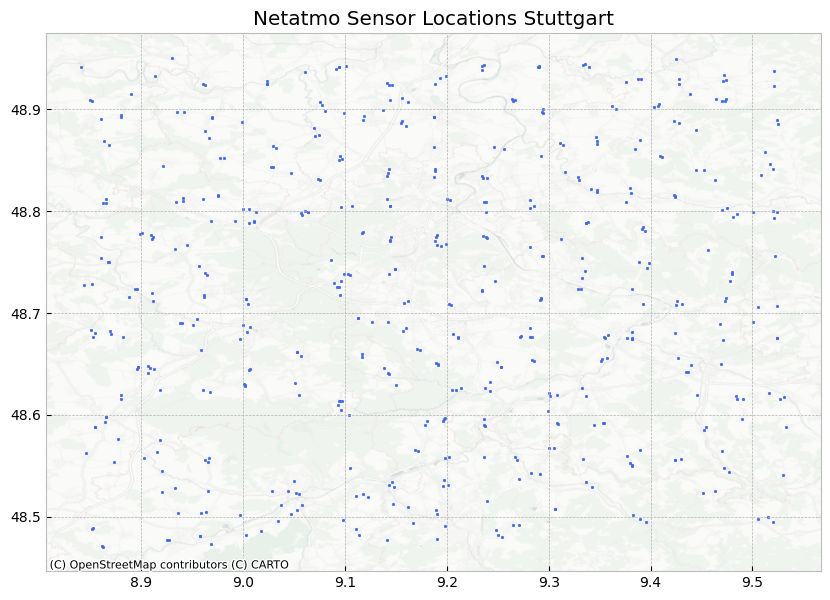

In [7]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily

# Read netatmo data
df = pd.read_csv("data/netatmo/june_stuttgart/stuttgart_19_06_23_14_00_00.csv", sep=";", parse_dates=["time"])
netatmo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lat, df.lon), crs=proj_wgs)

# Convert columns to float also for rows windstrength, windangle, guststrength, gustangle
netatmo_df["temperature"] = netatmo_df["temperature"].astype(float)
netatmo_df["humidity"] = netatmo_df["humidity"].astype(float)
netatmo_df["pressure"] = netatmo_df["pressure"].astype(float)
netatmo_df["windstrength"] = netatmo_df["windstrength"].astype(float)
netatmo_df["windangle"] = netatmo_df["windangle"].astype(float)
netatmo_df["guststrength"] = netatmo_df["guststrength"].astype(float)
netatmo_df["gustangle"] = netatmo_df["gustangle"].astype(float)
netatmo_df["rain"] = netatmo_df["rain"].astype(float)

# Convert timestamp to datetime
# netatmo_df["time"] = pd.to_datetime(netatmo_df["time"])
netatmo_df = netatmo_df[netatmo_df['time'] == '2023-06-19 15:00:00'] # offset by 1 hour due to timezone and wrong handling

netatmo_df.dropna(subset=['temperature'], inplace=True)

min= 27.0
max= 35.5

print(len(netatmo_df))

netatmo_df = netatmo_df[(netatmo_df['temperature'] >= min) & (netatmo_df['temperature'] <= max)]

print(len(netatmo_df))

netatmo_df = netatmo_df[netatmo_df.geometry.within(bounding_box)].set_index('station_id')

print(len(netatmo_df))

print(netatmo_df)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

netatmo_df.plot(ax=ax, marker='o', color='royalblue', markersize=3)

ax.set_title('Netatmo Sensor Locations Stuttgart')

# Add basemap
contextily.add_basemap(
    ax,
    crs=proj_wgs,
    source=contextily.providers.CartoDB.PositronNoLabels,
)

Load Google EE Data

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
import ee
from geopandas import GeoDataFrame, GeoSeries
from geopandas.tools import sjoin
# from src.google_ee_data_helpers import get_ndvi_data

# Stuttgart bounding box
# lat1, lon1 = 48.9519, 8.8402
# lat2, lon2 = 48.4698, 9.5348

lat1 = 48.9519
lon1 = 8.8402
lat2 = 48.4698
lon2 = 9.5348

region = ee.Geometry.BBox(lon1, lat2, lon2, lat1)

def get_dataset(dataset_name, start_date, end_date, region, scale, bands):
    dataset = (
        ee.ImageCollection(dataset_name)
        .filterDate(start_date, end_date)
    )

    dataset = dataset.select(bands)

    clipped_dataset = dataset.getRegion(region, scale).getInfo()

    df = ee_array_to_df(clipped_dataset, bands)

    return df

def get_ndvi_data(start_date, end_date):
    return get_dataset('MODIS/061/MOD13A1', start_date, end_date, region, 500, ['NDVI'])

def get_evi_data(start_date, end_date):
    return get_dataset('MODIS/061/MOD13A1', start_date, end_date, region, 500, ['EVI'])

def get_elevation_data(start_date, end_date):
    return get_dataset('COPERNICUS/DEM/GLO30', start_date, end_date, region, 500, ['DEM'])

def clip_to_region(image):
  return image.clip(region)

def point_grid_to_cells(gdf):
    """Converts a GeoDataFrame of points to a GeoDataFrame of polygons."""
    xmin, ymin, xmax, ymax= gdf.total_bounds

    x_cells = len(gdf.geometry.x.unique())
    cell_size = (xmax-xmin)/x_cells

    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append(box(x0, y0, x1, y1))
    
    cell = GeoDataFrame(grid_cells, columns=['geometry'], crs=proj_wgs)
    return cell

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    # df = df[['time','datetime',  *list_of_bands]]
    df.drop(['time'], axis=1, inplace=True)

    gdf = GeoDataFrame(df, geometry=df[[
    'longitude', 'latitude']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=proj_wgs)

    cells = point_grid_to_cells(gdf)

    return sjoin(cells, gdf, how='left', predicate='contains').drop('index_right', axis=1)


# Hamburg
# lat1, lon1 = 53.65326, 9.86917
# lat2, lon2 = 53.48455, 10.15370

# # Create a bounding box geometry
bounding_box = box(lon1, lat1, lon2, lat2)

start_date = '2023-06-05'
end_date = '2023-06-11'

ndvi_df = get_ndvi_data(start_date, end_date)
evi_df = get_evi_data(start_date, end_date)
elevation_df = get_elevation_data('2006-01-01', '2011-05-31') # DEM data is only available until 2011-05-31

# Create combined for sensor.community

combined_df = sjoin(gdf_day, ndvi_df, how='inner', predicate='within').drop(['index_right','longitude','latitude','datetime'], axis=1)
combined_df = sjoin(combined_df, evi_df, how='inner', predicate='within').drop(['index_right','longitude','latitude','datetime'], axis=1)
combined_df = sjoin(combined_df, elevation_df, how='inner', predicate='within').drop(['index_right','longitude','latitude','datetime'], axis=1)

print(combined_df.head())

# Create combined for netatmo
combined_df_netatmo = sjoin(netatmo_df.drop(['rain'], axis=1), ndvi_df, how='inner', predicate='within').drop(['index_right','longitude','latitude','datetime'], axis=1)
combined_df_netatmo = sjoin(combined_df_netatmo, evi_df, how='inner', predicate='within').drop(['index_right','longitude','latitude','datetime'], axis=1)
combined_df_netatmo = sjoin(combined_df_netatmo, elevation_df, how='inner', predicate='within').drop(['index_right','longitude','latitude','datetime'], axis=1)

print(combined_df_netatmo.head())

                   time    lon     lat      ta                  geometry  humidity    pressure    NDVI     EVI         DEM
113 2023-06-19 14:00:00  9.182  48.808  29.130  POINT (9.18200 48.80800)    45.175  97745.4300  6171.0  4602.0  291.196869
141 2023-06-19 14:00:00  9.160  48.778  33.385  POINT (9.16000 48.77800)    32.410  98122.0175  4362.0  2015.0  278.951447
292 2023-06-19 14:00:00  9.162  48.776  34.700  POINT (9.16200 48.77600)    59.950         NaN  4362.0  2015.0  278.951447
152 2023-06-19 14:00:00  9.164  48.792  29.100  POINT (9.16400 48.79200)    60.300         NaN  6222.0  4116.0  321.418579
210 2023-06-19 14:00:00  9.120  48.810  29.150  POINT (9.12000 48.81000)    52.875         NaN  8004.0  4739.0  339.220367
                                       time        lon       lat  temperature  pressure  humidity  windstrength  windangle  guststrength  gustangle                  geometry    NDVI     EVI         DEM
station_id                                                  

In [28]:
display(combined_df)

,time,lon,lat,ta,geometry,humidity,pressure,NDVI,EVI,DEM
113,2023-06-19 14:00:00,9.182000,48.808000,29.1300,POINT (9.18200 48.80800),45.1750,97745.4300,6171.0,4602.0,291.196869
141,2023-06-19 14:00:00,9.160000,48.778000,33.3850,POINT (9.16000 48.77800),32.4100,98122.0175,4362.0,2015.0,278.951447
292,2023-06-19 14:00:00,9.162000,48.776000,34.7000,POINT (9.16200 48.77600),59.9500,NaN,4362.0,2015.0,278.951447
152,2023-06-19 14:00:00,9.164000,48.792000,29.1000,POINT (9.16400 48.79200),60.3000,NaN,6222.0,4116.0,321.418579
210,2023-06-19 14:00:00,9.120000,48.810000,29.1500,POINT (9.12000 48.81000),52.8750,NaN,8004.0,4739.0,339.220367
...,...,...,...,...,...,...,...,...,...,...
56103,2023-06-19 14:00:00,9.280000,48.774000,31.0750,POINT (9.28000 48.77400),68.9750,NaN,7050.0,4379.0,345.127869
61645,2023-06-19 14:00:00,8.997248,48.686796,28.7425,POINT (8.99725 48.68680),39.9900,96249.3600,2897.0,1598.0,432.266541
76611,2023-06-19 14:00:00,9.062000,48.534000,35.3550,POINT (9.06200 48.53400),22.0725,96661.5775,6509.0,4668.0,442.100464
77865,2023-06-19 14:00:00,9.040000,48.524000,30.3250,POINT (9.04000 48.52400),35.3500,NaN,6696.0,5033.0,334.974609


In [108]:
test_df = combined_df.copy()
test_df.reset_index(inplace=True)

nr_neighbours = 30

# Add neighbour temperatures
# Add sitances to neighbours
for i in range(1, nr_neighbours + 1):
    test_df[f'distance_{i}'] = np.nan
    test_df[f'ta_{i}'] = np.nan

locations = list(test_df['geometry'].apply(lambda x: (x.x, x.y)))
location_df = pd.DataFrame(locations)

# More build time but better query time
tree = KDTree(locations, balanced_tree=True)

for index, row in test_df.iterrows():
    coords = row["geometry"].coords
    distance_df = get_neighbour_distances_from_coords(coords, tree, nr_neighbours)

    # neighbours = test_df.merge(distance_df, how='inner', suffixes=('', '_right'))
    neighbours = test_df.loc[distance_df.index]
    distance_df.reset_index(inplace=True)

    for i, neighbour_row in distance_df.iloc[1:].iterrows():
        ind = int(neighbour_row['index'])
        distance = neighbour_row['distance']
        ta = combined_df.iloc[ind].ta
        row[f'ta_{i}'] = ta
        row[f'distance_{i}'] = distance

    test_df.loc[index] = row

test_df.fillna(-1, inplace=True)
display(test_df)

,index,time,lon,lat,ta,geometry,humidity,pressure,NDVI,EVI,...,distance_26,ta_26,distance_27,ta_27,distance_28,ta_28,distance_29,ta_29,distance_30,ta_30
0,113,2023-06-19 14:00:00,9.182000,48.808000,29.1300,POINT (9.18200 48.80800),45.1750,97745.4300,6171.0,4602.0,...,4.576647,32.100,5.062379,30.300000,5.062379,31.300,5.094552,29.725,5.110824,32.600
1,141,2023-06-19 14:00:00,9.160000,48.778000,33.3850,POINT (9.16000 48.77800),32.4100,98122.0175,4362.0,2015.0,...,4.264481,31.975,4.270255,31.375000,4.270255,29.850,4.445547,31.725,4.721308,31.680
2,292,2023-06-19 14:00:00,9.162000,48.776000,34.7000,POINT (9.16200 48.77600),59.9500,-1.0000,4362.0,2015.0,...,4.188688,29.130,4.218000,31.725000,4.241304,31.975,4.527929,29.850,4.792321,32.825
3,152,2023-06-19 14:00:00,9.164000,48.792000,29.1000,POINT (9.16400 48.79200),60.3000,-1.0000,6222.0,4116.0,...,4.372893,31.725,4.842703,31.050000,4.852104,28.905,4.889043,32.250,5.225259,33.050
4,210,2023-06-19 14:00:00,9.120000,48.810000,29.1500,POINT (9.12000 48.81000),52.8750,-1.0000,8004.0,4739.0,...,7.107468,34.150,7.203891,30.133333,7.220974,34.800,7.751456,31.050,7.820578,31.975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,56103,2023-06-19 14:00:00,9.280000,48.774000,31.0750,POINT (9.28000 48.77400),68.9750,-1.0000,7050.0,4379.0,...,7.933200,33.245,8.071769,29.340000,8.162841,35.650,8.669377,32.100,8.813148,32.400
134,61645,2023-06-19 14:00:00,8.997248,48.686796,28.7425,POINT (8.99725 48.68680),39.9900,96249.3600,2897.0,1598.0,...,13.438676,30.475,13.773094,29.995000,13.901017,31.255,14.438132,28.125,15.318916,29.750
135,76611,2023-06-19 14:00:00,9.062000,48.534000,35.3550,POINT (9.06200 48.53400),22.0725,96661.5775,6509.0,4668.0,...,19.723048,29.200,21.152711,30.752500,21.208715,28.310,21.342041,28.125,21.358200,28.620
136,77865,2023-06-19 14:00:00,9.040000,48.524000,30.3250,POINT (9.04000 48.52400),35.3500,-1.0000,6696.0,5033.0,...,20.483034,29.200,20.544298,33.175000,20.551493,32.425,21.554804,28.310,21.699293,28.620


## Comparison

In [109]:
# Day time gdf with all features: combined_df
results = []

for gdf in [test_df]:
    print(f"Starting with {gdf.time.values[0]}...")

    for regr in [KNeighborsRegressor(n_neighbors=30), RandomForestRegressor(n_estimators=200), HistGradientBoostingRegressor(max_iter=200), svm.SVR()]:
        X,y = gdf.drop(['time', 'geometry', 'ta'], axis=1).values, gdf['ta'].values

        # KNN is scale sensisitive, so all input features need to be scaled
        clf = make_pipeline(StandardScaler(), regr)
        rmse = make_scorer(mean_squared_error, greater_is_better=True, squared=False)
        r2 = make_scorer(r2_score, greater_is_better=True, force_finite=True)
        scoring = {
            'rmse': rmse,
            'r2': "r2"
        }

        pipe = make_pipeline()
        scores = cross_validate(clf, X, y, cv=10, scoring=scoring)

        for i in range(9):
            new = pd.DataFrame({
                "time": gdf.time.values[0],
                "type": type(regr).__name__,
                "RMSE": scores['test_rmse'][i],
                "R2": scores['test_r2'][i]
                }, index=[0])
            
            results.append(new)

eval_df = pd.concat(results)
print(eval_df.head(11))

Starting with 2023-06-19T14:00:00.000000000...
                 time                   type      RMSE        R2
0 2023-06-19 14:00:00    KNeighborsRegressor  1.987780  0.106384
0 2023-06-19 14:00:00    KNeighborsRegressor  1.762273  0.195815
0 2023-06-19 14:00:00    KNeighborsRegressor  1.682636  0.094405
0 2023-06-19 14:00:00    KNeighborsRegressor  1.599992  0.185404
0 2023-06-19 14:00:00    KNeighborsRegressor  1.302141  0.031773
0 2023-06-19 14:00:00    KNeighborsRegressor  1.255151 -0.104738
0 2023-06-19 14:00:00    KNeighborsRegressor  1.352780  0.089867
0 2023-06-19 14:00:00    KNeighborsRegressor  1.337008 -0.164183
0 2023-06-19 14:00:00    KNeighborsRegressor  1.431971 -0.214795
0 2023-06-19 14:00:00  RandomForestRegressor  1.864019  0.214194
0 2023-06-19 14:00:00  RandomForestRegressor  1.798581  0.162337


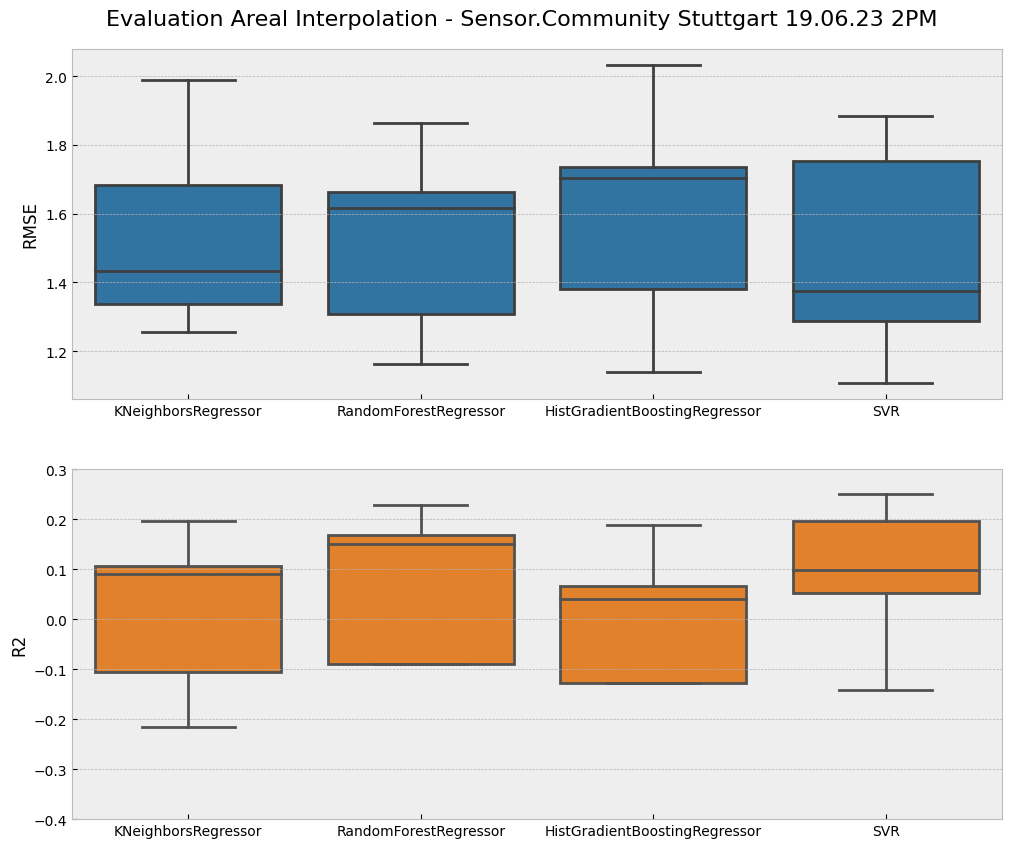

In [119]:
color_palette = sns.color_palette('tab10')  # You can choose other palettes or define custom colors

fig, axs = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle(F'Evaluation Areal Interpolation - Sensor.Community Stuttgart 19.06.23 2PM', fontsize=16, y=0.92)

eval_coords = eval_df[eval_df["time"] == "2023-06-19 14:00:00"]
eval_night = eval_df[eval_df["time"] == "2023-06-19 05:00:00"]

# Set the 'hue' parameter in each lineplot call to differentiate the lines based on the 'hue' value
sns.boxplot(data=eval_coords, x='type', y='RMSE', ax=axs[0], color=color_palette[0])
sns.boxplot(data=eval_coords, x='type', y='R2', ax=axs[1], color=color_palette[1])

axs[0].set_xlabel(None)
axs[1].set_xlabel(None)

axs[0].set_ylabel('RMSE')
axs[1].set_ylabel('R2')
axs[1].set_ylim(-0.4, 0.3)

# Create a custom legend for each subplot
# custom_lines = [Line2D([0], [0], color=color_palette[0], lw=2),
#                 Line2D([0], [0], color=color_palette[1], lw=2)]

# axs[0].legend(handles=custom_lines, labels=['RMSE', 'R2'], loc='upper right')
# axs[1].legend(handles=custom_lines, labels=['RMSE', 'R2'], loc='upper left')

plt.show()

## Map Generation